In [1]:
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

In [2]:
from google.cloud import bigquery

client = bigquery.Client(project="trelis-arc")

table_name = "trelis-arc.arc.partials_for_refinement"
file_name = table_name.split('.')[-1]

In [11]:
create_final_table_query = f"""
CREATE OR REPLACE TABLE `{table_name}` AS

WITH arc_2_eval_tasks AS (
    SELECT DISTINCT task_id
    FROM `trelis-arc.arc.arc_task_ids`
    WHERE subset = "arc-agi-2/evaluation"
),
-- Clean programs by collapsing multiple empty lines into single empty lines
programs_cleaned AS (
    SELECT 
        k.row_id,
        k.task_id,
        -- Clean code by collapsing multiple consecutive newlines into at most one empty line
        -- Pattern matches multiple consecutive newlines with optional whitespace
        REGEXP_REPLACE(k.code, r'\\n(\\s*\\n)+', '\\n\\n') as code,
        k.model,
        k.reasoning,
        k.predicted_train_output,
        k.predicted_test_output,
        k.correct_train_input,
        k.correct_test_input,
        k.is_transductive
    FROM `trelis-arc.arc.superking` k
    WHERE NOT EXISTS (
        SELECT 1
        FROM arc_2_eval_tasks e
        WHERE e.task_id = k.task_id
    )
),
-- Calculate metrics and filter by grid size
programs_with_metrics AS (
    SELECT 
        row_id,
        task_id,
        code,
        model,
        predicted_train_output,
        predicted_test_output,
        correct_train_input,
        correct_test_input,
        is_transductive,
        reasoning,
        LENGTH(code) as program_length,
        -- Check if all train inputs are correct
        (SELECT LOGICAL_AND(correct_val.element) 
         FROM UNNEST(correct_train_input.list) AS correct_val) as all_train_correct,
        -- Check if all test inputs are correct
        (SELECT LOGICAL_AND(correct_val.element) 
         FROM UNNEST(correct_test_input.list) AS correct_val) as all_test_correct,
        -- Count correct examples
        (SELECT COUNTIF(correct_val.element) 
         FROM UNNEST(correct_train_input.list) AS correct_val) + 
        (SELECT COUNTIF(correct_val.element) 
         FROM UNNEST(correct_test_input.list) AS correct_val) as total_correct,
        ARRAY_LENGTH(correct_train_input.list) + ARRAY_LENGTH(correct_test_input.list) as total_possible,
        -- Check grid sizes for train output
        (SELECT MAX(ARRAY_LENGTH(grid_2d.element.list)) 
         FROM UNNEST(predicted_train_output.list) AS grid_2d) as max_train_grid_height,
        (SELECT MAX(ARRAY_LENGTH(row_1d.element.list)) 
         FROM UNNEST(predicted_train_output.list) AS grid_2d,
              UNNEST(grid_2d.element.list) AS row_1d) as max_train_grid_width,
        -- Check grid sizes for test output
        (SELECT MAX(ARRAY_LENGTH(grid_2d.element.list)) 
         FROM UNNEST(predicted_test_output.list) AS grid_2d) as max_test_grid_height,
        (SELECT MAX(ARRAY_LENGTH(row_1d.element.list)) 
         FROM UNNEST(predicted_test_output.list) AS grid_2d,
              UNNEST(grid_2d.element.list) AS row_1d) as max_test_grid_width,
        -- Normalize code for deduplication (remove all whitespace, lowercase)
        LOWER(REGEXP_REPLACE(code, r'\\s+', '')) as normalized_code
    FROM programs_cleaned
),
-- Filter by grid size (40x40) and require at least one correct
programs_filtered AS (
    SELECT *,
        -- Calculate success rate for ranking
        SAFE_DIVIDE(total_correct, total_possible) as success_rate
    FROM programs_with_metrics
    WHERE max_train_grid_height <= 40 AND max_train_grid_width <= 40
      AND max_test_grid_height <= 40 AND max_test_grid_width <= 40
      AND total_correct > 0
      AND NOT all_test_correct
      AND NOT is_transductive
),
-- Find shortest, most correct program per task
task_benchmarks AS (
    SELECT 
        task_id,
        MIN(program_length) as shortest_best_length
    FROM (
        SELECT 
            task_id,
            program_length,
            ROW_NUMBER() OVER (
                PARTITION BY task_id 
                ORDER BY success_rate DESC, program_length ASC, code ASC
            ) as rank
        FROM programs_filtered
    ) ranked
    WHERE rank = 1
    GROUP BY task_id
),
-- Deduplicate programs (same normalized code + task_id)
programs_deduplicated AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (
            PARTITION BY task_id, normalized_code
            ORDER BY success_rate DESC, program_length ASC, model ASC, code ASC
        ) as dedup_rank
    FROM programs_filtered
),
final_selection AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (
            PARTITION BY task_id 
            ORDER BY success_rate DESC, MD5(code) ASC
        ) as final_rank
    FROM programs_deduplicated
    WHERE dedup_rank = 1
)
SELECT row_id, task_id, code, model, predicted_train_output, predicted_test_output,
       correct_train_input, correct_test_input, is_transductive, reasoning
FROM final_selection
WHERE final_rank <= 10
ORDER BY task_id, final_rank
"""

print("Executing BigQuery table creation...")
job = client.query(create_final_table_query)
result = job.result()
print(f"✓ Table `{table_name}` created successfully")

Executing BigQuery table creation...
✓ Table `trelis-arc.arc.partials_for_refinement` created successfully


In [3]:
from llm_python.datasets.bigquery_export import load_bigquery_table_as_dataframe

# Load BigQuery table as DataFrame using our reusable function
print("Loading BigQuery table data...")
raw_data = load_bigquery_table_as_dataframe(
    client=client,
    table_name=table_name
)
print(f"Loaded {len(raw_data)} programs from BigQuery table")

Loading BigQuery table data...
Exporting BigQuery table 'trelis-arc.arc.partials_for_refinement' to GCS...
Waiting for BigQuery export to complete...
✓ Export to GCS completed successfully
✓ Download completed
Reading parquet file...
Loaded 6563 rows from BigQuery table
Loaded 6563 programs from BigQuery table


In [4]:
from llm_python.datasets.bigquery_converter import convert_bigquery_to_soar

print("Converting BigQuery data to SOAR format...")
raw_dataset = convert_bigquery_to_soar(raw_data, show_progress=True)

Converting BigQuery data to SOAR format...


Converting BQ to SOAR: 100%|██████████| 6563/6563 [00:00<00:00, 6860.77it/s]

Successfully converted 6563 programs from 6563 input rows


In [5]:
from llm_python.datasets.validation import (
    validate_soar_dataframe,
    validate_soar_dataframe_correctness,
)


validation_result = validate_soar_dataframe(raw_dataset)
print(validation_result.summary())
if not validation_result.is_valid:
    raise ValueError(
        "Validation failed: Some programs do not meet the schema requirements."
    )

correctness_result = validate_soar_dataframe_correctness(raw_dataset)
print(correctness_result.summary())
if not correctness_result.is_valid:
    raise ValueError(
        "Validation failed: Some programs do not meet the correctness requirements."
    )

Format validation:
    Total programs: 6563
    Schema valid: PASS
    Business logic valid: PASS
    Issues: 0
Correctness validation:
    Total programs: 6563
    Sample size: 1000
    Correctness valid: PASS
    Errors: 0


In [ ]:

from llm_python.datasets.io import write_soar_parquet

output_path = f"/tmp/{file_name}.parquet"
print(f"Saving final dataset to: {output_path}")
write_soar_parquet(raw_dataset, output_path)

raw_dataset schema:
row_id                    object
task_id                   object
reasoning                 object
code                      object
correct_train_input       object
correct_test_input        object
predicted_train_output    object
predicted_test_output     object
model                     object
is_transductive             bool
dtype: object
Saving final dataset to: /tmp/partials_for_refinement.parquet


DATASET STATISTICS ANALYSIS: partials_for_refinement
1. Computing basic statistics...
📊 Basic Statistics:
   • Unique tasks: 807
   • Total programs: 6,563
   • Fully correct programs: 0 (0.0%)
   • Partially correct programs: 6,563 (100.0%)
   • Completely incorrect programs: 0 (0.0%)
   • Average correctness rate: 0.490

2. Computing per-task distributions...
📈 Per-task Statistics:
   • Average programs per task: 8.1
   • Median programs per task: 10.0
   • Min programs per task: 1
   • Max programs per task: 10
   • Tasks with 10 programs (max): 578
   • Tasks with fully correct programs: 0
   • Tasks with no correct programs: 807

3. Computing quantile distribution of programs per task...
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 1.0
   • 25th percentile: 7.0
   • 50th percentile (median): 10.0
   • 75th percentile: 10.0
   • 90th percentile: 10.0
   • 95th percentile: 10.0
   • 99th percentile: 10.0
   • 100th percentile (max): 10.0

4. Creating visua

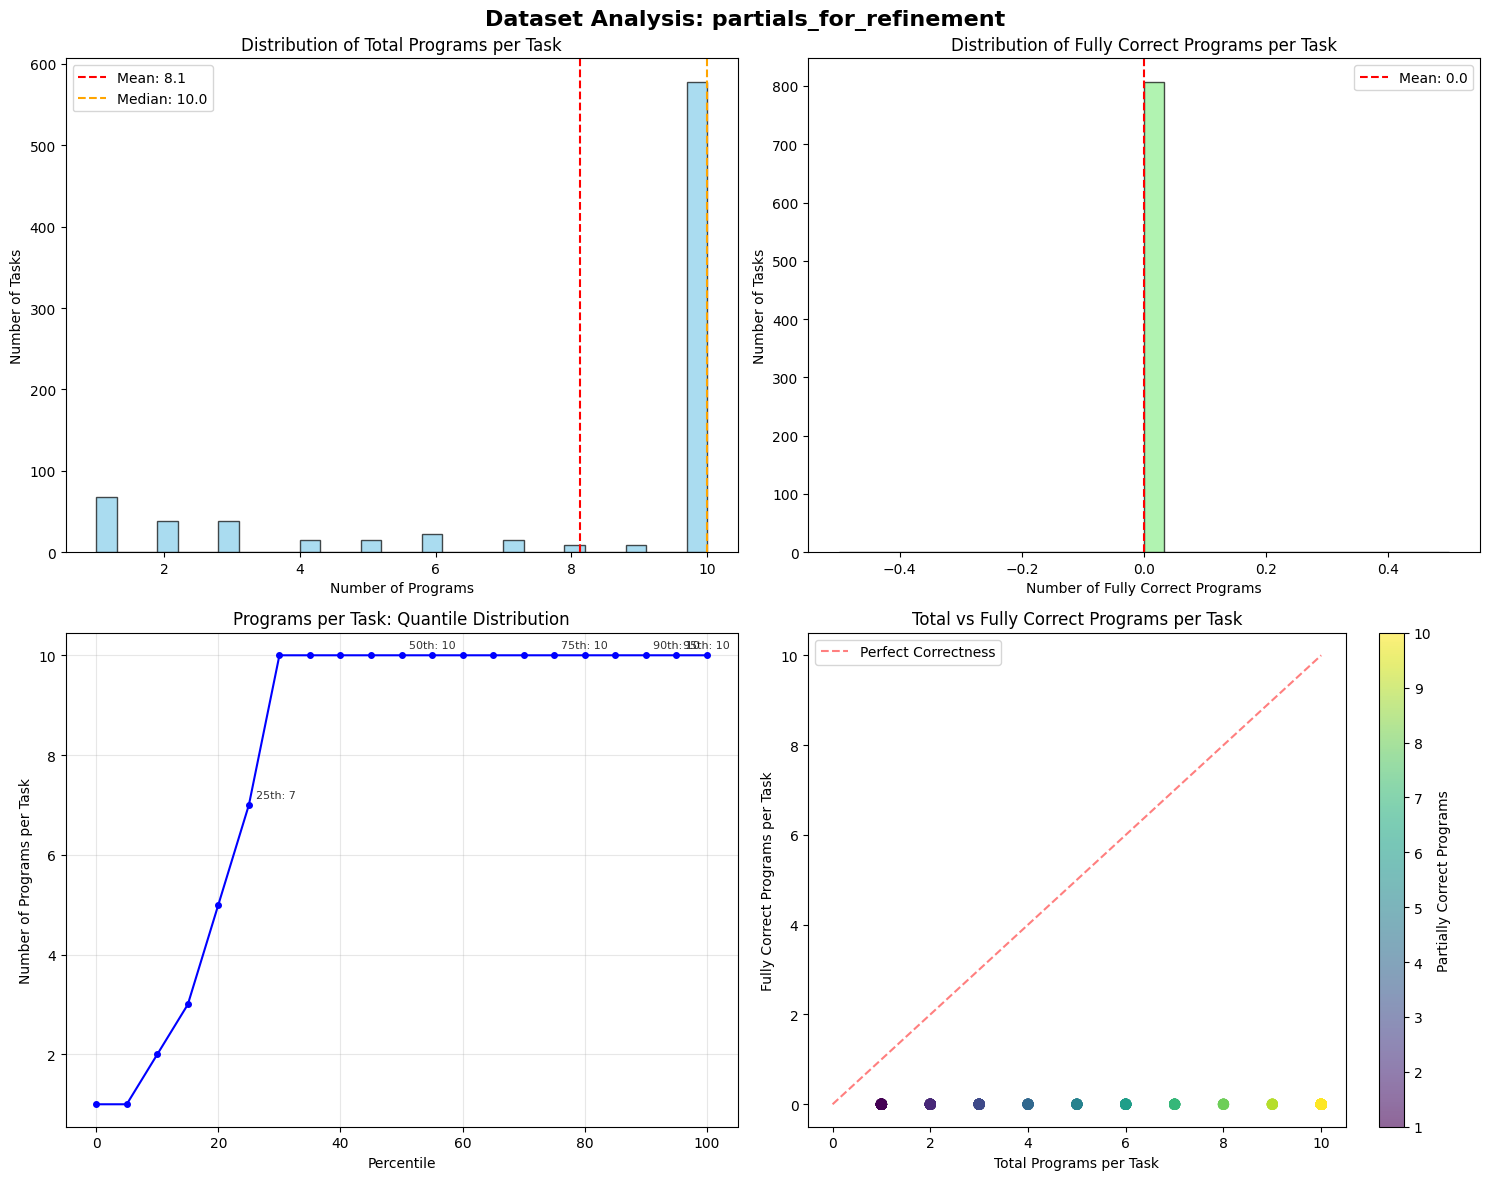


✓ Analysis complete! Generated visualizations showing:
   • Program distribution patterns across tasks
   • Quantile distribution of programs per task
   • Relationship between total and correct programs per task


In [8]:
from llm_python.datasets.statistics import analyze_dataset_statistics

analyze_dataset_statistics(raw_dataset, file_name)